In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
import scipy as sp
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt

c:\Users\greno\Documents\Prog\MATH221\ma221_proj\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


kspace: (8, 230, 180) complex64


EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 118.29it/s]


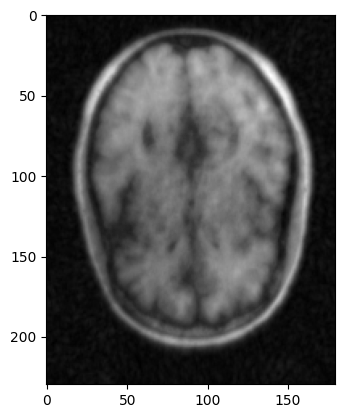

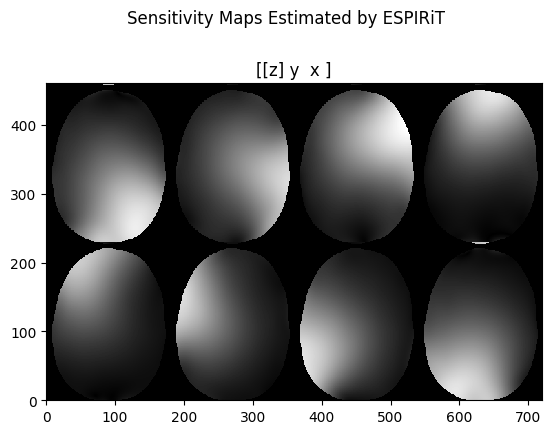

Sensitivity maps: (8, 230, 180) complex64


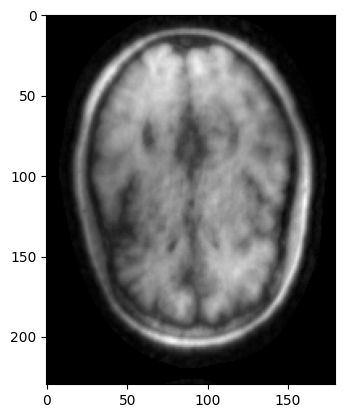

In [460]:
ksp_path = "../sigpy-mri-tutorial/data/"
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)



img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

#### Sigpy SENSE recon

SenseRecon: 100%|██████████| 10/10 [00:00<00:00, 31.34it/s, resid=1.12E-01]


(230, 180) complex64


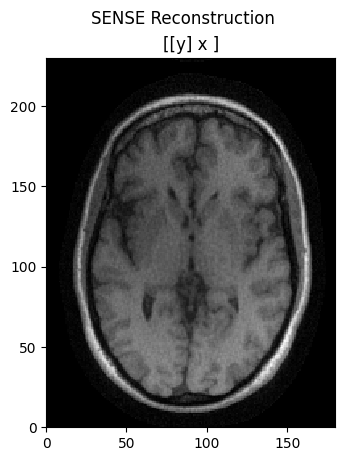

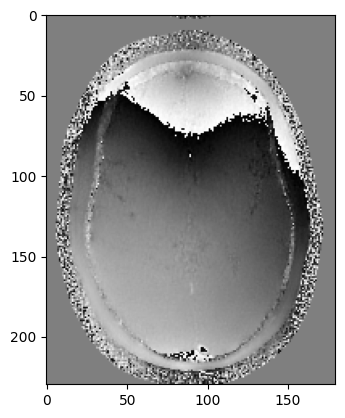

In [463]:
lamda = 0.01
# 32 bit
img_sense_32 = mr.app.SenseRecon(ksp, mps, lamda=1e-2, solver='ConjugateGradient', max_iter=10).run()
print(img_sense_32.shape, img_sense_32.dtype)
pl.ImagePlot(img_sense_32, title='SENSE Reconstruction')
plt.imshow(np.flip(np.angle(img_sense_32)), cmap='gray')


#### manual condition number for k-space and recon'd image

In [4]:
# kspace
for x in range(ksp.shape[0]):
    uk, sk, vk = np.linalg.svd(ksp[x,:,:])
    cnk = sk.max()/sk.min()
    print('Coil ' + str(x) + ' condition number:',  cnk)

# image
ui, si, vi = np.linalg.svd(img_sense_32)
cni = si.max()/si.min()
print('Reconstructed image condition number:', cni)

Coil 0 condition number: 1.2597259e+16
Coil 1 condition number: 1.2113975e+16
Coil 2 condition number: 1.3448391e+16
Coil 3 condition number: 1.2242645e+16
Coil 4 condition number: 1.3362672e+16
Coil 5 condition number: 1.3218598e+16
Coil 6 condition number: 1.1186882e+16
Coil 7 condition number: 1.299929e+16
Reconstructed image condition number: 1.3673977e+16


#### numpy/CG-SENSE recon

(230, 180) (230, 180) (230, 180)


Text(0.5, 1.0, 'Phase')

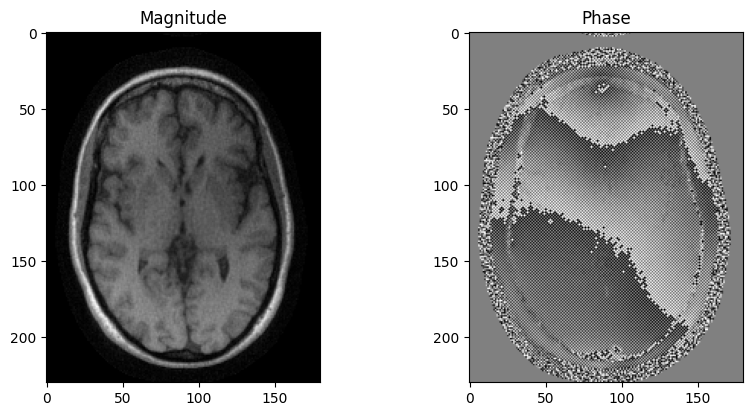

In [478]:
import sigpy.mri


def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def conjugate_sense_reconstruction(kspace, sensitivity_maps, num_iters=100, lamda=1e-2, tol=1e-10, use_fp16=False):
    """
    Conjugate Gradient SENSE MRI Reconstruction
    
    Parameters:
    - kspace: numpy array of shape (num_coil, nrows, ncols), the k-space data
    - sensitivity_maps: numpy array of shape (num_coil, nrows, ncols), sensitivity maps
    - num_iters: int, number of iterations for the CG algorithm
    - lamda: float, regularization parameter
    - tol: float, tolerance for stopping condition
    
    Returns:
    - x: numpy array of shape (nrows, ncols), complex-valued reconstructed image
    """
    
    # making linear operator FSx
    ishape = (kspace.shape[1], kspace.shape[2]) # image shape

    def get_weights(y):
        return (np.sqrt(np.sum(np.square(y), axis=0)) > 0).astype(y.dtype)
    
    W = get_weights(kspace)

    def forward_op(x):
        #return A(x)
        """Forward operation: SENSE forward model."""
        shifted_image = np.fft.fftshift(x*sensitivity_maps, axes=(-2,-1)) # need to shift
        res =  np.fft.fft2(shifted_image, ishape, norm='ortho', axes=(-2,-1))
        return W**0.5 * res
    
    # x* FHSH
    def adjoint_op(y):
        #return A.H(y)
        """Adjoint operation: SENSE adjoint model."""
        ifft_result = np.fft.ifft2(W**0.5*y, ishape, norm='ortho',  axes=(-2,-1))
        shifted_ifft_result = np.fft.ifftshift(ifft_result, axes=(-2,-1)) # need to shift
        return np.sum(np.conj(sensitivity_maps) * shifted_ifft_result, axis=0)

    # Define AHA operator: A^H A + lambda I
    def normal_op(x):
        #return x + lamda * x
        """Normal equation operator: A^H A + lambda I"""
        result = adjoint_op(forward_op(x)) + x * lamda
        if use_fp16:
            return to_fp16(result)
        else:
            return result
    
    # Compute AHy (adjoint of k-space)
    if use_fp16:
        AHy = to_fp16(adjoint_op(kspace))
    else:
        AHy = adjoint_op(kspace) 
    # init
    x = np.zeros_like(AHy)  # 0s init
    r = np.zeros_like(AHy)  # 0s init
    if use_fp16:
        r = to_fp16(AHy - normal_op(x))
    else:   
        r = AHy - normal_op(x) 
    z = r.copy() # if preconditioning here)
    p = z.copy()

    print(x.shape, r.shape, p.shape)
    rz_old = np.real(np.vdot(r, z))
    resid = np.sqrt(rz_old)

    # now do cg iterations
    for i in range(num_iters):
        if use_fp16:
            Ap = to_fp16(normal_op(p))
        else:
            Ap = normal_op(p) 
        pAp = np.real(np.vdot(p, Ap))

        if pAp <= 0:
            print("Matrix not positive definite. Stopping.")
            break
        #print(x.shape, r.shape, p.shape)
        alpha = rz_old / pAp
        x += alpha * p
        r -= alpha * Ap

        if use_fp16:
            z = to_fp16(r)  # No preconditioning
        else:
            z = r.copy()
        rz_new = np.real(np.vdot(r, z))

        resid = np.sqrt(rz_new)

        if resid < tol:
            print(f'Converged after {i+1} iterations with residual {resid}')
            break

        beta = (rz_new / rz_old)
        if use_fp16:
            p = to_fp16(z + beta * p)
        else:
            p = z + beta * p
        rz_old = rz_new
    return x


def dumb_solve(ksp, mps, lamda):
    fs = []
    for i in range(mps.shape[0]):
        fs.append(np.fft.fft2(np.eye(ksp.shape[1],ksp.shape[2])))
    F = np.block(fs)
    def apply_fft(M, n_coils):
        h = M.shape[0]//(n_coils-1)
        w = M.shape[1]
        RES = np.zeros_like(M)
        for i in range(n_coils):
            RES[i*h:(i+1)*h, :] = np.fft.fft2(M[i*h:(i+1)*h, :])
        return RES
    mpss = []
    for i in range(mps.shape[0]):
        mpss.append([mps[i]])
    xs = []
    for i in range(ksp.shape[0]):
        xs.append(ksp[i].T)
    S = np.block(mpss)
    X = np.block(xs)
    print(S.shape, X.shape, F.shape)
    A = apply_fft(S, 8)
    AH = np.conj(A.T)
    AHA = AH@A
    print(A.shape, AH.shape, AHA.shape)

    img = np.linalg.lstsq(AHA, X.T@AH)
    print(img[0].shape)
    return img[0]


recon_img = conjugate_sense_reconstruction(ksp, mps, num_iters=10, lamda=1e-2)
#recon_img2 = dumb_solve(ksp, mps, lamda=1e-2)
#recon_img_16b = conjugate_sense_reconstruction(ksp_complex32, mps_complex32, lamda=1e-2, use_fp16=True) 

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(np.abs(np.flip(recon_img)), cmap='gray')
plt.title('Magnitude')
plt.subplot(222)
plt.imshow(np.angle(np.flip(recon_img)), cmap='gray')
plt.title('Phase')

#plt.subplot(223)
#plt.imshow(np.abs(np.flip(recon_img2)), cmap='gray')
#plt.title('Magnitude, fp16')
##plt.subplot(224)
#plt.imshow(np.angle(np.flip(recon_img_16b)), cmap='gray')
#plt.title('Phase, fp16')



#### sigpy L1 wavelet recon

L1WaveletRecon: 100%|██████████| 100/100 [00:04<00:00, 24.10it/s, resid=8.58E-03]


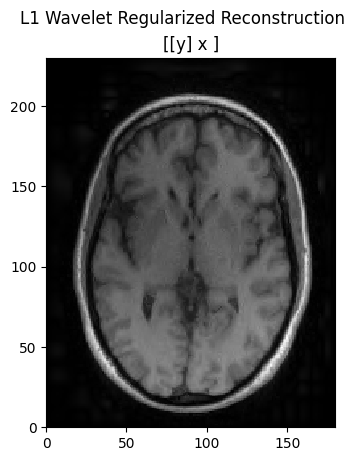

SenseRecon: 100%|██████████| 10/10 [00:00<00:00, 32.31it/s, resid=1.35E-01]


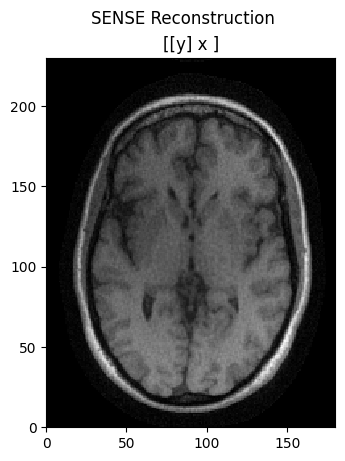

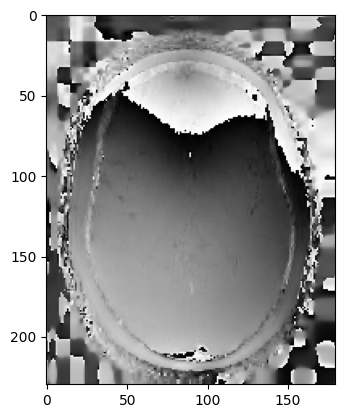

In [251]:
lamda = 0.005
img_l1wav = mr.app.L1WaveletRecon(ksp, mps, lamda).run()

pl.ImagePlot(img_l1wav, title='L1 Wavelet Regularized Reconstruction')
img_sense_32 = mr.app.SenseRecon(ksp, mps, lamda=lamda, solver='ConjugateGradient', max_iter=10).run()

pl.ImagePlot(img_sense_32, title='SENSE Reconstruction')
plt.imshow(np.flip(np.angle(img_l1wav)), cmap='gray')